In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import spacy
from nltk.metrics.distance import edit_distance
nlp = spacy.load("en_core_web_sm")

[2025-05-02 11:33:29,060] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: /usr/local/cuda-12/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/praveen/miniconda3/envs/emnlp/compiler_compat/ld: /usr/local/cuda-12/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXX

In [2]:
domain = pd.read_csv("/home/praveen/theoden/emnlp_25/dataset/domain_qa.csv")
forget_20_1 = pd.read_parquet("hf://datasets/Shiyu-Lab/Wikipedia_Person_Unlearn/forget_20_1/train-00000-of-00001.parquet")

In [26]:
df = pd.merge(
    forget_20_1,
    domain,
    on="title",
    how="inner",
    suffixes=("_forget", "_domain")
)

### semantic similarity

In [5]:
semantic_gte = pd.read_csv('similarity_scores.csv')

In [15]:
semantic_gte['semantic_score_docs'].describe()

count    120.000000
mean       0.576917
std        0.063851
min        0.370000
25%        0.540000
50%        0.570000
75%        0.620000
max        0.710000
Name: semantic_score_docs, dtype: float64

In [23]:
semantic_summary = semantic_gte.groupby(['title', 'SimilarName'])['semantic_score_docs'].mean().reset_index()

# Sort by title and semantic score in descending order
semantic_summary = semantic_summary.sort_values(['title', 'semantic_score_docs'], ascending=[True, False])

# Optional: Format the display to show all similar names for each title
for title in semantic_summary['title'].unique():
    print(f"\nTitle: {title}")
    subset = semantic_summary[semantic_summary['title'] == title]
    for _, row in subset.iterrows():
        print(f"  {row['SimilarName']}: {row['semantic_score_docs']:.2f}")


Title: Adrienne Monnier
  Sylvia Beach: 0.71
  Djuna Barnes: 0.57
  Gertrude Stein: 0.52
  T.S. Eliot: 0.52
  Jane Heap: 0.51
  Anna_de_Noailles: 0.49

Title: Alfred Vogel
  Egon Friedell: 0.49
  Ernst Weiss: 0.47
  Klaus Mann: 0.44
  Bertolt Brecht: 0.41
  Ernst Toller: 0.39
  Heinrich Mann: 0.37

Title: Amy Clampitt
  Maxine Kumin: 0.59
  Elizabeth Bishop: 0.56
  Marilyn Hacker: 0.54
  Adrienne Rich: 0.53
  Anne Sexton: 0.53
  Sharon Olds: 0.53

Title: Ann Brashares
  Judy Blume: 0.58
  Emily Giffin: 0.55
  Meg Cabot: 0.54
  Megan McCafferty: 0.53
  Sara Shepard: 0.53
  Jennifer Weiner: 0.51

Title: Benedetto Varchi
  Francesco Petrarca: 0.65
  Giovanni Boccaccio: 0.63
  Dante Alighieri: 0.61
  Lorenzo de Medici: 0.60
  Leonardo Bruni: 0.57
  Leon Battista Alberti: 0.53

Title: Elsa Triolet
  Colette: 0.60
  Nathalie Sarraute: 0.56
  Simone de Beauvoir: 0.55
  Marguerite Duras: 0.54
  Francoise Sagan: 0.52
  Anais Nin: 0.51

Title: Giovanni Battista Casti
  Pietro Metastasio: 0.67
 

### Token level similarity

In [30]:
from collections import Counter
import math
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy 

In [31]:
def simple_tokenize(text):
    """Basic whitespace tokenizer, lowercases."""
    if not isinstance(text, str):
        return []
    return text.lower().split()

In [39]:
def compare_documents_kl_jsd(doc1_text, doc2_text, smoothing=1e-9):
    """Compares token distributions of two docs using KL and JSD."""
    print(f"\n--- Comparing Documents using KL/JSD ---")
    tokens1 = simple_tokenize(doc1_text)
    tokens2 = simple_tokenize(doc2_text)

    if not tokens1 or not tokens2:
        print("One or both documents have no tokens.")
        return float('nan'), float('nan')

    counts1 = Counter(tokens1)
    counts2 = Counter(tokens2)
    n1 = len(tokens1)
    n2 = len(tokens2)

    vocab = set(tokens1) | set(tokens2)
    vocab_size = len(vocab)

    # Create probability vectors aligned to the combined vocabulary
    p1 = np.zeros(len(vocab))
    p2 = np.zeros(len(vocab))

    vocab_list = list(vocab)
    token_to_idx = {token: i for i, token in enumerate(vocab_list)}

    for token, count in counts1.items():
        idx = token_to_idx[token]
        # Smoothed probability
        p1[idx] = (count + smoothing) / (n1 + vocab_size * smoothing)

    for token, count in counts2.items():
        idx = token_to_idx[token]
        # Smoothed probability
        p2[idx] = (count + smoothing) / (n2 + vocab_size * smoothing)

    # Normalize to ensure they sum to 1 after potential smoothing adjustments
    p1 /= p1.sum()
    p2 /= p2.sum()

    # KL Divergence (P1 || P2) - How P1 differs from P2
    # Note: entropy calculates D(pk || qk)
    #kl_12 = entropy(p1, p2)
    # KL Divergence (P2 || P1) - How P2 differs from P1
    #kl_21 = entropy(p2, p1)

    # Jensen-Shannon Divergence (symmetric)
    jsd = round(jensenshannon(p1, p2, base=2), 2) #jensenshannon(p1, p2, base=2) # base=2 for bits

    print(f"Doc 1: '{doc1_text[:50]}...'")
    print(f"Doc 2: '{doc2_text[:50]}...'")
    #print(f"KL(Doc1 || Doc2): {kl_12:.4f} nats") # scipy entropy uses nats (base e)
    #print(f"KL(Doc2 || Doc1): {kl_21:.4f} nats")
    print(f"JSD(Doc1, Doc2):  {jsd:.4f} bits") # scipy jensenshannon uses bits

    # Lower JSD/KL means more similar distributions.
    # JSD is bounded [0, 1] for base 2. KL is >= 0.

    return jsd #kl_12,

In [43]:
df2 = df[['title', 'SimilarName', 'wikipage', 'content']]

df2.drop_duplicates(subset=['title', 'SimilarName', 'wikipage', 'content'], inplace=True)
df2 = df2.dropna(subset=['wikipage', 'content'])
df2['content'] = df2['content'].astype(str)
df2['wikipage'] = df2['wikipage'].astype(str)

/tmp/ipykernel_3615344/1411115755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(subset=['title', 'SimilarName', 'wikipage', 'content'], inplace=True)


In [44]:
df2['token_level_similarity'] = df2.apply(lambda row: compare_documents_kl_jsd(row['wikipage'], row['content']), axis=1)


--- Comparing Documents using KL/JSD ---
Doc 1: 'Benedetto Varchi (Italian pronunciation: [beneˈdet...'
Doc 2: 'Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-ee-o...'
JSD(Doc1, Doc2):  0.7200 bits

--- Comparing Documents using KL/JSD ---
Doc 1: 'Benedetto Varchi (Italian pronunciation: [beneˈdet...'
Doc 2: 'Francis Petrarch (/ˈpɛtrɑːrk, ˈpiːt-/; 20 July 130...'
JSD(Doc1, Doc2):  0.7500 bits

--- Comparing Documents using KL/JSD ---
Doc 1: 'Benedetto Varchi (Italian pronunciation: [beneˈdet...'
Doc 2: 'Leonardo Bruni[a] or Leonardo Aretino (c. 1370 – M...'
JSD(Doc1, Doc2):  0.7400 bits

--- Comparing Documents using KL/JSD ---
Doc 1: 'Benedetto Varchi (Italian pronunciation: [beneˈdet...'
Doc 2: 'Dante Alighieri (Italian: [ˈdante aliˈɡjɛːri]; mos...'
JSD(Doc1, Doc2):  0.7200 bits

--- Comparing Documents using KL/JSD ---
Doc 1: 'Benedetto Varchi (Italian pronunciation: [beneˈdet...'
Doc 2: 'Lorenzo di Piero de' Medici (Italian: [loˈrɛntso d...'
JSD(Doc1, Doc2):  0.7300 bits

--- Compa

In [45]:
token_similarity_summary = df2.groupby(['title', 'SimilarName'])['token_level_similarity'].mean().reset_index()

# Sort by title and semantic score in descending order
token_similarity_summary = token_similarity_summary.sort_values(['title', 'token_level_similarity'], ascending=[True, False])

# Optional: Format the display to show all similar names for each title
for title in token_similarity_summary['title'].unique():
    print(f"\nTitle: {title}")
    subset = token_similarity_summary[token_similarity_summary['title'] == title]
    for _, row in subset.iterrows():
        print(f"  {row['SimilarName']}: {row['token_level_similarity']:.2f}")


Title: Adrienne Monnier
  Anna_de_Noailles: 0.80
  Jane Heap: 0.77
  Gertrude Stein: 0.75
  T.S. Eliot: 0.75
  Djuna Barnes: 0.73
  Sylvia Beach: 0.71

Title: Alfred Vogel
  Ernst Toller: 0.80
  Heinrich Mann: 0.80
  Egon Friedell: 0.79
  Ernst Weiss: 0.79
  Bertolt Brecht: 0.78
  Klaus Mann: 0.78

Title: Amy Clampitt
  Anne Sexton: 0.79
  Sharon Olds: 0.79
  Adrienne Rich: 0.78
  Elizabeth Bishop: 0.77
  Marilyn Hacker: 0.77
  Maxine Kumin: 0.76

Title: Ann Brashares
  Emily Giffin: 0.79
  Sara Shepard: 0.79
  Jennifer Weiner: 0.78
  Judy Blume: 0.77
  Meg Cabot: 0.76
  Megan McCafferty: 0.76

Title: Benedetto Varchi
  Francesco Petrarca: 0.75
  Leonardo Bruni: 0.74
  Leon Battista Alberti: 0.73
  Lorenzo de Medici: 0.73
  Dante Alighieri: 0.72
  Giovanni Boccaccio: 0.72

Title: Elsa Triolet
  Anais Nin: 0.80
  Francoise Sagan: 0.80
  Nathalie Sarraute: 0.80
  Marguerite Duras: 0.79
  Simone de Beauvoir: 0.79
  Colette: 0.78

Title: Giovanni Battista Casti
  Antonio Vivaldi: 0.77
  C

### making a test set

In [ ]:
#new_df = pd.merge(semantic_gte, df2, how='left', on=['title', 'SimilarName'])

#new_df = new_df[['title', 'SimilarName', 'wikipage_x', 'content_x', 'semantic_score_docs', 'token_level_similarity']]

#new_df.to_csv('similarity_scores.csv', index=False)

In [3]:
new_df = pd.read_csv('similarity_scores.csv')


In [3]:
new_df.head()

,title,SimilarName,wikipage_x,content_x,semantic_score_docs,token_level_similarity
0,Benedetto Varchi,Giovanni Boccaccio,Benedetto Varchi (Italian pronunciation: [bene...,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,0.63,0.72
1,Benedetto Varchi,Francesco Petrarca,Benedetto Varchi (Italian pronunciation: [bene...,"Francis Petrarch (/ˈpɛtrɑːrk, ˈpiːt-/; 20 July...",0.65,0.75
2,Benedetto Varchi,Leonardo Bruni,Benedetto Varchi (Italian pronunciation: [bene...,Leonardo Bruni[a] or Leonardo Aretino (c. 1370...,0.57,0.74
3,Benedetto Varchi,Dante Alighieri,Benedetto Varchi (Italian pronunciation: [bene...,Dante Alighieri (Italian: [ˈdante aliˈɡjɛːri];...,0.61,0.72
4,Benedetto Varchi,Lorenzo de Medici,Benedetto Varchi (Italian pronunciation: [bene...,Lorenzo di Piero de' Medici (Italian: [loˈrɛnt...,0.60,0.73


In [4]:
def split_test_retain(df, strategy='highest_semantic',
                      score_col_semantic='semantic_score_docs',
                      score_col_token='token_level_similarity',
                      group_col='title',
                      item_col='SimilarName'):
    """
    Splits the DataFrame into a test set (one item per group) and a retain set (the rest).

    Args:
        df (pd.DataFrame): Input dataframe with columns like 'title', 'SimilarName',
                           'semantic_score_docs', 'token_level_similarity'.
                           Assumes each 'title' group has multiple 'SimilarName' rows.
        strategy (str): The strategy for selecting the test item per group.
                        Options: 'highest_semantic', 'lowest_semantic', 'median_semantic',
                                 'highest_token', 'lowest_token', 'median_token',
                                 'random'.
        score_col_semantic (str): Name of the semantic score column.
        score_col_token (str): Name of the token-level score column.
        group_col (str): Name of the column to group by (e.g., 'title').
        item_col (str): Name of the column representing the items within group (e.g., 'SimilarName').

    Returns:
        tuple: A tuple containing (test_set_df, retain_set_df)
    """
    print(f"Splitting data using strategy: {strategy}")

    required_cols = [group_col, item_col]
    if 'semantic' in strategy:
        required_cols.append(score_col_semantic)
    if 'token' in strategy:
        required_cols.append(score_col_token)

    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing required columns for strategy '{strategy}': {required_cols}")

    test_indices = []

    # Group by the main title
    grouped = df.groupby(group_col)

    if strategy == 'random':
        # Sample one index randomly from each group
        test_indices = grouped.apply(lambda x: x.sample(1)).index.get_level_values(1) # Get original index
    elif strategy in ['highest_semantic', 'lowest_semantic', 'median_semantic',
                      'highest_token', 'lowest_token', 'median_token']:

        ascending_order = True # Default for lowest/median calculation start
        score_column = score_col_semantic if 'semantic' in strategy else score_col_token

        if 'highest' in strategy:
            ascending_order = False # Highest score comes first when descending

        # Sort within each group by the chosen score
        df_sorted = df.sort_values([group_col, score_column], ascending=[True, ascending_order])
        grouped_sorted = df_sorted.groupby(group_col)

        if 'highest' in strategy or 'lowest' in strategy:
             # Take the first item after sorting (either highest or lowest)
            test_indices = grouped_sorted.head(1).index
        elif 'median' in strategy:
            # Find the index corresponding to the median position
            def get_median_index(group):
                n = len(group)
                # Index position (0-based) for median. For even N, take lower of the two middle.
                median_idx_pos = (n - 1) // 2
                return group.iloc[[median_idx_pos]].index # Return the original index

            test_indices = grouped_sorted.apply(get_median_index).explode() # Apply returns MultiIndex, explode fixes it

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # Create the test and retain sets using the collected indices
    test_set_df = df.loc[test_indices]
    retain_set_df = df[~df.index.isin(test_indices)] # Select rows whose index is NOT in test_indices

    print(f"Test set shape: {test_set_df.shape}")
    print(f"Retain set shape: {retain_set_df.shape}")

    # Verification (optional but recommended)
    if not (len(test_set_df) == df[group_col].nunique()):
         print(f"Warning: Test set size ({len(test_set_df)}) does not match unique groups ({df[group_col].nunique()}). Check input data.")
    if not (len(test_set_df) + len(retain_set_df) == len(df)):
         print(f"Warning: Total size after split ({len(test_set_df) + len(retain_set_df)}) does not match original size ({len(df)}). Check logic.")

    return test_set_df, retain_set_df

In [5]:
strategy_to_use = 'random' # 'lowest_semantic', 'median_semantic', 'random', 'highest_token','highest_semantic' 

In [6]:
test_set, retain_set = split_test_retain(
    new_df,
    strategy=strategy_to_use,
    score_col_semantic='semantic_score_docs', 
    score_col_token='token_level_similarity', 
    group_col='title',
    item_col='SimilarName'
)

Splitting data using strategy: random
Test set shape: (20, 6)
Retain set shape: (100, 6)


/tmp/ipykernel_20578/2350038790.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_indices = grouped.apply(lambda x: x.sample(1)).index.get_level_values(1) # Get original index


In [8]:
test_set.shape

(20, 6)

In [9]:
retain_set.shape

(100, 6)

### syntactic similarity

In [7]:
def get_pos_sequence(sentence):
    """
    Parse the sentence and return its sequence of POS tags.
    """
    doc = nlp(sentence)
    return [token.pos_ for token in doc]

def syntactic_similarity(sentence1, sentence2):
    """
    Compute a syntactic similarity score based on the edit distance
    between the sequences of POS tags from two sentences.

    The score is normalized between 0 and 1, where 1 indicates identical structure.
    """
    pos_seq1 = get_pos_sequence(sentence1)
    pos_seq2 = get_pos_sequence(sentence2)

    # Compute the edit distance between the two POS tag sequences.
    distance = edit_distance(pos_seq1, pos_seq2)

    # Normalize the distance by the length of the longer sequence.
    max_len = max(len(pos_seq1), len(pos_seq2))
    normalized_distance = distance / max_len if max_len != 0 else 0

    # Normalizin similarity score
    similarity = 1 - normalized_distance
    return round(similarity, 2)


In [8]:
df["syntactic_score"] = df.apply(
    lambda row: syntactic_similarity(row["question_forget"], row["question_domain"]),
    axis=1
)


In [9]:
df.columns

Index(['title', 'question_forget', 'answer_forget', 'paraphrased_question',
       'wikipage', 'SimilarName', 'content', 'question_domain',
       'answer_domain', 'section', 'difficulty', 'syntactic_score'],
      dtype='object')

In [12]:
df['syntactic_score'].describe()

count    7029.000000
mean        0.402124
std         0.137757
min         0.080000
25%         0.310000
50%         0.380000
75%         0.470000
max         1.000000
Name: syntactic_score, dtype: float64

In [12]:
qf_summary = df.groupby(['title', 'question_forget'])['syntactic_score'].mean().reset_index()
print("Question_forget Summary:")
qf_summary.head()

Question_forget Summary:


,title,question_forget,syntactic_score
0,Adrienne Monnier,What era is Adrienne Monnier known to have bee...,0.333846
1,Adrienne Monnier,What notable English language bookstore was in...,0.326410
2,Adrienne Monnier,What professions did Adrienne Monnier pursue?,0.423974
3,Adrienne Monnier,Where was Adrienne Monnier born?,0.460128
4,Alfred Vogel,How old was Alfred Vogel at the time of his de...,0.372881


In [15]:
qf_summary['title'].nunique()

20

In [26]:
# Group by title, similarName and question_domain to get the mean syntactic score:
qd_summary = df.groupby(['title', 'SimilarName', 'question_forget', 'question_domain'])['syntactic_score'].mean().reset_index()
print("Question_domain Summary:")
qd_summary.head()


Question_domain Summary:


,title,SimilarName,question_forget,question_domain,syntactic_score
0,Adrienne Monnier,Anna_de_Noailles,What era is Adrienne Monnier known to have bee...,What award did Anna de Noailles receive in 1921?,0.36
1,Adrienne Monnier,Anna_de_Noailles,What era is Adrienne Monnier known to have bee...,What was Anna de Noailles' descent?,0.43
2,Adrienne Monnier,Anna_de_Noailles,What era is Adrienne Monnier known to have bee...,What was Anna de Noailles' profession?,0.43
3,Adrienne Monnier,Anna_de_Noailles,What era is Adrienne Monnier known to have bee...,When did Anna de Noailles die?,0.29
4,Adrienne Monnier,Anna_de_Noailles,What era is Adrienne Monnier known to have bee...,When was Anna de Noailles born?,0.29


In [ ]:
similar_names = {
    'Benedetto Varchi': ['Giovanni Boccaccio', 'Francesco Petrarca', 'Leonardo Bruni', 'Dante Alighieri', 'Lorenzo de Medici', 'Leon Battista Alberti'],
    'Wilhelm Wattenbach': ['Leopold von Ranke', 'Theodor Mommsen', 'Georg Waitz', 'Heinrich von Sybel', 'Friedrich Meinecke', 'Ernst Dümmler'],
    'Elsa Triolet': ['Colette', 'Simone de Beauvoir', 'Francoise Sagan', 'Nathalie Sarraute', 'Marguerite Duras', 'Anais Nin'],
    'Theopompus': ['Herodotus', 'Thucydides', 'Xenophon', 'Polybius', 'Diodorus Siculus', 'Ctesias'],
    'Heinrich Ritter': ['Immanuel Kant', 'Wilhelm von Humboldt', 'Friedrich Nietzsche', 'Arthur Schopenhauer', 'Friedrich Schelling', 'Johann Gottlieb Fichte'],
    'Adrienne Monnier': ['Sylvia Beach', 'Jane Heap', 'T.S. Eliot', 'Anna_de_Noailles', 'Djuna Barnes', 'Gertrude Stein'],
    'Ann Brashares': ['Judy Blume', 'Sara Shepard', 'Meg Cabot', 'Megan McCafferty', 'Emily Giffin', 'Jennifer Weiner'],
    'Hartmann von Aue': ['Wolfram von Eschenbach', 'Gottfried von Strassburg', 'Walter von der Vogelweide', 'Ulrich von Hutten', 'Reinmar der Alte', 'Reinmar von Hagenau'],
    'Jorge Semprún': ['Vicente Aleixandre', 'Rafael Alberti', 'Camilo Jose Cela', 'Miguel Delibes', 'Mario Vargas Llosa', 'Carlos Fuentes'],
    'Giovanni Battista Casti': ['Carlo Goldoni', 'Pietro Metastasio', 'Alessandro Scarlatti', 'Giovanni Paisiello', 'Christoph Willibald Gluck', 'Antonio Vivaldi'],
    'Najaf Daryabandari': ['Sadegh Hedayat', 'Mohammad-Taqi Bahar', 'Simin Daneshvar', 'Sadeq Chubak', 'Sohrab Sepehri', 'Bahram Beyzaie'],
    'Heinz Erhardt': ['Heinz_Rühmann', 'Dieter Hildebrandt', 'Werner Finck', 'Harald Schmidt', 'Otto Waalkes', 'Loriot'],
    'Rudolf Christoph Eucken': ['Friedrich Nietzsche', 'Arthur Schopenhauer', 'Edmund Husserl', 'Martin Heidegger', 'Karl Jaspers', 'Ernst Troeltsch'],
    'Paul Gerhardt': ['Philipp Nicolai', 'Georg Philipp Telemann', 'Nicolaus Herman', 'Johann Heermann', 'Simon Dach', 'Johann Franck'],
    'Moshe Greenberg': ['Abraham Joshua Heschel', 'Martin Buber', 'Joseph B. Soloveitchik', 'Gerhard von Rad', 'Walter Brueggemann', 'Franz Rosenzweig'],
    'Amy Clampitt': ['Elizabeth Bishop', 'Anne Sexton', 'Adrienne Rich', 'Maxine Kumin', 'Marilyn Hacker', 'Sharon Olds'],
    'Ted Kooser': ['Billy Collins', 'Rita Dove', 'Kay Ryan', 'Mark Doty', 'Joy Harjo', 'Philip_Levine_(poet)'],
    'Alfred Vogel': ['Bertolt Brecht', 'Heinrich Mann', 'Klaus Mann', 'Egon Friedell', 'Ernst Toller', 'Ernst Weiss'],
    'Siegfried Lenz': ['Heinrich Boll', 'Gunter Grass', 'Wolfgang Koeppen', 'Martin Walser', 'Peter Handke', 'Hans Magnus Enzensberger'],
    'Philip Stanhope, 5th Earl Stanhope': ['Thomas Babington Macaulay', 'Henry Hallam', 'Francis Palgrave', 'William Stubbs', 'James Anthony Froude', 'Lord Acton']
}


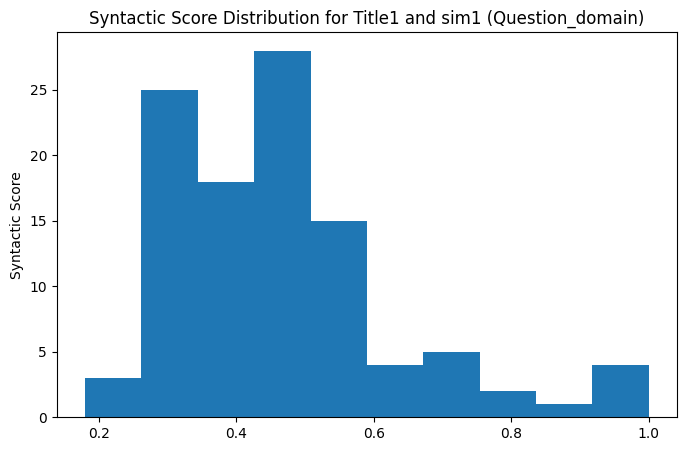

In [29]:
import matplotlib.pyplot as plt

# Suppose you want to plot the distribution of syntactic scores for question_domain for a given title and similarName
subset = df[(df['title'] == 'Benedetto Varchi') & (df['SimilarName'] == 'Giovanni Boccaccio')]
plt.figure(figsize=(8,5))
plt.hist(subset['syntactic_score'])
plt.title("Syntactic Score Distribution for Title1 and sim1 (Question_domain)")
plt.ylabel("Syntactic Score")
plt.show()


### retain set semantic similarity calculation

In [3]:
retain = pd.read_csv('full_retain_qa.csv')

In [4]:
retain.head()

,title,question,answer,type
0,Adele,What is Adele's full name?,Adele Laurie Blue Adkins,general
1,Adele,What was the title of Adele's debut album?,19,general
2,Adele,For which James Bond film did Adele release th...,Skyfall,general
3,Adele,What is the title of Adele's first song?,Hometown Glory,general
4,Adele,How many copies has Adele's debut album sold i...,Over 2.5 million,general


In [5]:
full_set = pd.read_csv('full_set.csv')

In [7]:
full_set['dataset'].value_counts()

dataset
retain    1801
test       738
forget      98
Name: count, dtype: int64

In [47]:
retain_with_wiki = pd.read_csv('retain_with_entities.csv')

In [9]:
retain_with_wiki.head()

,title,question,answer,extracted_entities,wikipedia_url,wiki_content
0,Benedetto Varchi,In which Italian region is Montevarchi located?,Tuscany,Montevarchi,https://en.wikipedia.org/?curid=4966967,Montevarchi is a town and comune in the provin...
1,Benedetto Varchi,Which Italian dialect served as the basis for ...,Florentine dialect,Standard Italian,https://en.wikipedia.org/?curid=14708,"Italian (italiano, pronounced [itaˈljaːno] ⓘ, ..."
2,Benedetto Varchi,When did Ezra Pound begin writing The Cantos?,1915,Ezra Pound,https://en.wikipedia.org/?curid=44203,Ezra Weston Loomis Pound (30 October 1885 – 1 ...
3,Benedetto Varchi,How many sections are in The Cantos?,120,The Cantos,https://en.wikipedia.org/?curid=1176422,The Cantos is a long modernist poem by Ezra Po...
4,Benedetto Varchi,What was the name of the council that ruled th...,Signoria of Florence,Republic of Florence,https://en.wikipedia.org/?curid=292676,The Republic of Florence (Latin: Res publica F...


In [37]:
retain = pd.read_csv('/home/praveen/theoden/emnlp_25/retain_20_1.csv')
forget = pd.read_csv('/home/praveen/theoden/emnlp_25/forget_20_1.csv')

In [13]:
retain.head()

,title,question,answer
0,Benedetto Varchi,In which Italian region is Montevarchi located?,Tuscany
1,Benedetto Varchi,Which Italian dialect served as the basis for ...,Florentine dialect
2,Benedetto Varchi,When did Ezra Pound begin writing The Cantos?,1915
3,Benedetto Varchi,How many sections are in The Cantos?,120
4,Benedetto Varchi,What was the name of the council that ruled th...,Signoria of Florence


In [18]:
forget.head()

,title,question,answer,paraphrased_question,wikipage
0,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...
1,Benedetto Varchi,What professions did Benedetto Varchi have?,"Humanist, historian, poet",What were the professions of Benedetto Varchi?,Benedetto Varchi (Italian pronunciation: [bene...
2,Benedetto Varchi,Where was Benedetto Varchi born?,Florence,In which city was Benedetto Varchi born?,Benedetto Varchi (Italian pronunciation: [bene...
3,Benedetto Varchi,Who commissioned Benedetto Varchi to write a h...,Cosimo I,Which ruler asked Benedetto Varchi to document...,Benedetto Varchi (Italian pronunciation: [bene...
4,Benedetto Varchi,When was Varchi's Storia fiorentina first publ...,1721,In what year was the Storia fiorentina by Bene...,Benedetto Varchi (Italian pronunciation: [bene...


In [39]:
semantic_entity = pd.merge(
    forget,
    retain_with_wiki,
    how='left',
    on=['title']
)

In [23]:
semantic_entity.head()

,title,question_x,answer_x,paraphrased_question,wikipage,question_y,answer_y,extracted_entities,wikipedia_url,wiki_content
0,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,In which Italian region is Montevarchi located?,Tuscany,Montevarchi,https://en.wikipedia.org/?curid=4966967,Montevarchi is a town and comune in the provin...
1,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,Which Italian dialect served as the basis for ...,Florentine dialect,Standard Italian,https://en.wikipedia.org/?curid=14708,"Italian (italiano, pronounced [itaˈljaːno] ⓘ, ..."
2,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,When did Ezra Pound begin writing The Cantos?,1915,Ezra Pound,https://en.wikipedia.org/?curid=44203,Ezra Weston Loomis Pound (30 October 1885 – 1 ...
3,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,How many sections are in The Cantos?,120,The Cantos,https://en.wikipedia.org/?curid=1176422,The Cantos is a long modernist poem by Ezra Po...
4,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,What was the name of the council that ruled th...,Signoria of Florence,Republic of Florence,https://en.wikipedia.org/?curid=292676,The Republic of Florence (Latin: Res publica F...


In [40]:
semantic_entity = semantic_entity[['title', 'question_x', 'answer_x', 'paraphrased_question', 'wikipage', 'extracted_entities', 'wiki_content', 'question_y', 'answer_y']]

In [44]:
semantic_entity.shape

(142, 9)

In [25]:
model = SentenceTransformer('Alibaba-NLP/gte-Qwen2-1.5B-instruct')

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
def compute_semantic_similarity(text1, text2):
    # Encode sentences
    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    # Compute cosine similarity
    similarity = util.cos_sim(embedding1, embedding2)
    # Return scalar float
    return round(float(similarity[0][0]),2)

In [29]:
from tqdm.auto import tqdm
tqdm.pandas()

In [31]:
semantic_entity['extracted_entities'].nunique()

185

In [42]:
semantic_entity.drop_duplicates(subset=['wikipage','wiki_content',], inplace=True)

In [45]:
semantic_entity.head()

,title,question_x,answer_x,paraphrased_question,wikipage,extracted_entities,wiki_content,question_y,answer_y
0,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,Montevarchi,Montevarchi is a town and comune in the provin...,In which Italian region is Montevarchi located?,Tuscany
1,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,Standard Italian,"Italian (italiano, pronounced [itaˈljaːno] ⓘ, ...",Which Italian dialect served as the basis for ...,Florentine dialect
2,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,Ezra Pound,Ezra Weston Loomis Pound (30 October 1885 – 1 ...,When did Ezra Pound begin writing The Cantos?,1915
3,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,The Cantos,The Cantos is a long modernist poem by Ezra Po...,How many sections are in The Cantos?,120
4,Benedetto Varchi,What nationality was Benedetto Varchi?,Italian,Which country was Benedetto Varchi from?,Benedetto Varchi (Italian pronunciation: [bene...,Republic of Florence,The Republic of Florence (Latin: Res publica F...,What was the name of the council that ruled th...,Signoria of Florence


In [46]:
semantic_entity["similarity_score"] = semantic_entity.progress_apply(
    lambda row: compute_semantic_similarity(
        row["wikipage"],
        row["wiki_content"]
    ),
    axis=1
)

  0%|          | 0/142 [00:00<?, ?it/s]

In [48]:
retain_with_wiki

,title,question,answer,extracted_entities,wikipedia_url,wiki_content
0,Benedetto Varchi,In which Italian region is Montevarchi located?,Tuscany,Montevarchi,https://en.wikipedia.org/?curid=4966967,Montevarchi is a town and comune in the provin...
1,Benedetto Varchi,Which Italian dialect served as the basis for ...,Florentine dialect,Standard Italian,https://en.wikipedia.org/?curid=14708,"Italian (italiano, pronounced [itaˈljaːno] ⓘ, ..."
2,Benedetto Varchi,When did Ezra Pound begin writing The Cantos?,1915,Ezra Pound,https://en.wikipedia.org/?curid=44203,Ezra Weston Loomis Pound (30 October 1885 – 1 ...
3,Benedetto Varchi,How many sections are in The Cantos?,120,The Cantos,https://en.wikipedia.org/?curid=1176422,The Cantos is a long modernist poem by Ezra Po...
4,Benedetto Varchi,What was the name of the council that ruled th...,Signoria of Florence,Republic of Florence,https://en.wikipedia.org/?curid=292676,The Republic of Florence (Latin: Res publica F...
...,...,...,...,...,...,...
359,"Philip Stanhope, 5th Earl Stanhope",Who held the position of Secretary to the Boar...,Henry Baillie,"""Board of Control""",https://en.wikipedia.org/?curid=564006,The Board of Control for Cricket in India (BCC...
360,"Philip Stanhope, 5th Earl Stanhope",When was the Royal Literary Fund founded?,1790,Royal Literary Fund,https://en.wikipedia.org/?curid=8785056,The Royal Literary Fund (RLF) is a benevolent ...
361,"Philip Stanhope, 5th Earl Stanhope",What year was the Royal Literary Fund granted ...,1818,Royal Literary Fund,https://en.wikipedia.org/?curid=8785056,The Royal Literary Fund (RLF) is a benevolent ...
362,"Philip Stanhope, 5th Earl Stanhope","When was Robert Smith, 1st Baron Carrington, b...",22 January 1752,"Robert Smith, 1st Baron Carrington",https://en.wikipedia.org/?curid=10512351,"Robert Smith, 1st Baron Carrington (22 January..."


In [50]:
retain_semantic = pd.merge(
    retain_with_wiki,
    semantic_entity,
    how='left',
    on=['wiki_content']
)

In [54]:
retain_semantic = retain_semantic[['title_x', 'question', 'answer', 'extracted_entities_x', 'wiki_content', 'similarity_score']]

In [55]:
retain_semantic['similarity_score'].describe()

count    364.000000
mean       0.471978
std        0.134314
min        0.050000
25%        0.370000
50%        0.480000
75%        0.580000
max        0.840000
Name: similarity_score, dtype: float64

In [56]:
full_retain = pd.read_csv('full_retain_qa.csv')

In [60]:
semantic_scores_entity = pd.merge(
    full_retain,
    retain_semantic,
    how='left',
    on=['question', 'answer']
)

In [62]:
semantic_scores_entity = semantic_scores_entity[['title', 'question', 'answer', 'type',  'similarity_score']]

In [65]:
domain_retain_qa = pd.read_csv('domain_retain_qa.csv')
domain_sem = pd.read_csv('similarity_scores.csv')

In [66]:
domain_retain_qa.head()

,title,SimilarName,content,question,answer,section,difficulty
0,Benedetto Varchi,Giovanni Boccaccio,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,When was Giovanni Boccaccio born?,16 June 1313,Birth and Family Background,Easy
1,Benedetto Varchi,Giovanni Boccaccio,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,Where was Giovanni Boccaccio born?,Florence or a village near Certaldo,Birth and Family Background,Medium
2,Benedetto Varchi,Giovanni Boccaccio,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,Who was Giovanni Boccaccio's father?,Boccaccino di Chellino,Family Background,Easy
3,Benedetto Varchi,Giovanni Boccaccio,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,What was the name of Giovanni Boccaccio's step...,Margherita de' Mardoli,Family Background,Medium
4,Benedetto Varchi,Giovanni Boccaccio,Giovanni Boccaccio (UK: /bəˈkætʃioʊ/ bə-KATCH-...,Where did Giovanni Boccaccio grow up?,Florence,Early Life,Easy


In [68]:
domain_sem = domain_sem[['title','SimilarName','semantic_score_docs']]

In [77]:
domain_semantic = pd.merge(
    domain_retain_qa,
    domain_sem,
    how='left',
    on=['title', 'SimilarName']
)

In [78]:
domain_semantic = domain_semantic[['question','answer','semantic_score_docs']]

In [75]:
semantic_scores_entity

,title,question,answer,type,similarity_score
0,Adele,What is Adele's full name?,Adele Laurie Blue Adkins,general,NaN
1,Adele,What was the title of Adele's debut album?,19,general,NaN
2,Adele,For which James Bond film did Adele release th...,Skyfall,general,NaN
3,Adele,What is the title of Adele's first song?,Hometown Glory,general,NaN
4,Adele,How many copies has Adele's debut album sold i...,Over 2.5 million,general,NaN
...,...,...,...,...,...
1796,Winston Churchill,How many times did Winston Churchill serve as ...,Twice,general,NaN
1797,Winston Churchill,During which years did Churchill first serve a...,1940 to 1945,general,NaN
1798,Winston Churchill,Which party did Churchill lead from 1940 to 1955?,Conservative Party,general,NaN
1799,Winston Churchill,What was Churchill's role in H. H. Asquith's L...,President of the Board of Trade and Home Secre...,general,NaN


In [79]:
domain_entity_semantic = pd.merge(
    semantic_scores_entity,
    domain_semantic,
    how='left',
    on=['question', 'answer']
)

In [84]:
domain_entity_semantic['similarity_score'] = domain_entity_semantic['similarity_score'].fillna(domain_entity_semantic['semantic_score_docs'])

In [87]:
domain_entity_semantic.drop(columns=['semantic_score_docs'], inplace=True)


In [89]:
domain_entity_semantic.to_csv('domain_entity_semantic.csv', index=False)

In [3]:
domain_entity_semantic = pd.read_csv('domain_entity_semantic.csv')

In [4]:
domain_entity_semantic.head()

,title,question,answer,type,similarity_score
0,Adele,What is Adele's full name?,Adele Laurie Blue Adkins,general,NaN
1,Adele,What was the title of Adele's debut album?,19,general,NaN
2,Adele,For which James Bond film did Adele release th...,Skyfall,general,NaN
3,Adele,What is the title of Adele's first song?,Hometown Glory,general,NaN
4,Adele,How many copies has Adele's debut album sold i...,Over 2.5 million,general,NaN
